# JUPYTER NOTEBOOK FOR HOMEWORK 2 - question 1
Extracting texture features and matching them for scene classification

In [6]:
import os, glob, time, sys
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

from skimage import io, transform
from skimage.filters.edges import convolve
import numpy as np
import joblib

from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler #use for data normalization

from makeLMfilters import makeLMfilters
np.random.seed(42)
CLUSTERCOUNT = 500

## 1. Load the training and testing images from the two .CSV files respectively

In [7]:
#Load the data along with the class labels
# Note, you will need to use the file folder name to determine the label of an image
# Convert the images to grayscale and resize them to 128 x 128
# (Optional) You might want to save your data here (to avoid repeating this step)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def loadTestImages():
    testImageArray = []
    testImageNames = []
    file = open("test250.csv","r")
    for line in file:
        imagePath = line.split(",")[0]
        imageName = line.split(",")[1]
        imageName = imageName.replace("\n","")
        if(imagePath!="filepath"):
            if os.path.isfile(os.getcwd() + '/' + imagePath):
                img = mpimg.imread(imagePath)
                img=transform.resize(img,(128,128))
                testImageArray.append(img)
                testImageNames.append(imageName)
    return [testImageArray,testImageNames]

def loadTrainImages():
    trainImageArray = []
    trainImageNames = []
    file = open("train250.csv","r")
    for line in file:
        imagePath = line.split(",")[0]
        imageName = line.split(",")[1]
        imageName = imageName.replace("\n","")
        if(imagePath!="filepath"):
            if os.path.isfile(os.getcwd() + '/' + imagePath):
                img = mpimg.imread(imagePath)
                img=transform.resize(img,(128,128))
                trainImageArray.append(img)
                trainImageNames.append(imageName)
    return [trainImageArray,trainImageNames]

## 2. Apply a bank of filters and generate features for training, testing and save the dataset

In [8]:
#. Using the overcomplete bank of filters F provided, convolve your input image with each filter in the bank
#  (make sure you check the dimensions of the returned array)
#

def getAbsFilterResponses( F, imggray ):
    rows, cols = imggray.shape
    num_filters = F.shape[2]
    responses = np.zeros((rows, cols, num_filters))

    #. Convolve the input image with every filter in the bank of filters 
    #   to get a response array; take the absolute value of the values in the array
    '*** Enter your code below'
    convResponses = [None] * num_filters
    for filtersIndex in range(0,num_filters):
        fb = F[:, :,filtersIndex]
        convResponses[filtersIndex] = convolve(imggray,fb)

    for r in range(0, rows):
        for c in range(0, cols):
            for f in range(0, num_filters):
                responses[r][c][f] = abs(convResponses[f][r][c])
    return responses


In [9]:
def apply_filter_bank( df, desc ):
    F = makeLMfilters() # This creates the over-complete bank of filters F
    X = np.array([])    # Initialize the numpy array to stack the responses for each image
    y = df[1]              # The label for each image
    responses = []
    for i in range(0,len(df[0])):
        temp = getAbsFilterResponses(F,df[0][i])
        responses.append(temp)
    X = np.array(responses)
    return X, y

In [10]:
## generate training and testing features, save them in a pickle with joblib
# NOTE: The code in this cell has been written for you
# NOTE2: This process can take a VERY LONG TIME...
#
train = loadTrainImages()
test = loadTestImages()
X_train, y_train = apply_filter_bank( train, 'Training -> ' )
X_test, y_test = apply_filter_bank( test, 'Testing -> ' )

# save the dataset, pickle using joblib
dataset = f'data.pkl'
obj = {
    'train': {
        'features': X_train,
        'label': y_train
    },
    'test': {
        'features': X_test,
        'label': y_test
    }
}

with open( dataset, 'wb' ) as f:
    joblib.dump( obj, f, compress=3 )

Load back the dataset (optional)
## 3. Run Kmeans with k=500 (recommended)
save the model again (optional)

In [11]:
# load back the dataset (optional)
# NOTE: The code in this cell has been written for you
dataset = f'data.pkl'
with open( dataset, 'rb' ) as f:
    obj = joblib.load( f )
print ( 'finished loading pkl file back')
    
X_train, y_train = obj['train']['features'], obj['train']['label']
X_test, y_test = obj['test']['features'], obj['test']['label']
print( f'X_train shape: {X_train.shape}; y_train shape: {len(y_train)}; X_test shape: {X_test.shape}; y_test shape: {len(y_test)}' )

finished loading pkl file back
X_train shape: (250, 128, 128, 48); y_train shape: 250; X_test shape: (250, 128, 128, 48); y_test shape: 250


In [12]:
# Vectorize the training set 
# NOTE: The vectorization code has been written for you below
reshape_X_train = X_train.reshape( -1, 48 )
print( f'Training dataset shape: {reshape_X_train.shape}' )
# normalize the the reshaped data (recommended to use MinMaxScaler)
scaler = MinMaxScaler()
scaler.fit(reshape_X_train)
reshape_X_train = scaler.transform(reshape_X_train)
# run kmeans (because the data is large, recommended to run minibatch kmeans)
# NOTE: This process can take a VERY LONG TIME...
'*** Enter your code below' 
kmeans = MiniBatchKMeans(n_clusters=CLUSTERCOUNT, random_state=0,init_size=CLUSTERCOUNT,max_iter = 500).fit(reshape_X_train)

# save kmeans model (optional)
# NOTE: The data saving code has been written for you below
model = f'kmeans_model.pkl'
with open( model, 'wb' ) as f:
    joblib.dump( kmeans, f, compress=3 )
print( f'Kmeans model saved.' )

Training dataset shape: (4096000, 48)
Kmeans model saved.


## 4. Generate the frequency histogram (feature) for each image

In [13]:
# load the model (optional)
model = f'kmeans_model.pkl'
with open( model, 'rb' ) as f:
    kmeans = joblib.load( f )

In [14]:
# Given an image response (already filtered) and the kmeans model, compute its frequency histogram
# a) Vectorize the response image
# b) Max-min normalize the response
# c) Predict clusters for each 48-dimensional pixel using the k-means predict function
# d) Generate the frequency histogram by incrementing the cluster centers where each pixel belongs
# e) Normalize the resulting frequency histogram so that it sums to 1
def calc_freq( img, kmeans ):
    vectorImg = img.reshape( -1, 48 )
    scaler = MinMaxScaler()
    scaler.fit(vectorImg)
    vectorImg = scaler.transform(vectorImg)
    predictedVal = kmeans.predict(vectorImg)
    clusterFrequency = [0] * CLUSTERCOUNT
    for val in predictedVal:
        clusterFrequency[val] = clusterFrequency[val] + (1/len(predictedVal))
    return clusterFrequency #this is the histogram feature representing an image

In [15]:
# loop through the set and call calc_freq on each image in the set (training and testing)
trainingDataFrequency = []
testingDataFrequency = []
for i in range(0,len(X_train)):
    trainingDataFrequency.append(calc_freq(X_train[i],kmeans))
for i in range(0,len(X_test)):
    testingDataFrequency.append(calc_freq(X_test[i],kmeans))

## 5. Implement the "nearest neighbor classifier" by comparing each image in Testing with the reference training images to generate a label.
Compare using chi-square distance measure

In [16]:
# Implement a function to calculate chi-square distance between 2 histograms ref and img
#
def calc_chi_sq(ref, img):
    dist = 0.0
    for index in range(0,len(img)):
        hi = ref[index]
        hj = img[index]
        if(hi+hj > 0):
            dist += (((hi - hj) ** 2)/(hi+hj))
    dist = dist*0.5
    return dist

In [17]:
#My classifier type which takes the median of all the similar classes 
#and compares the distance of testing data with distance of the median.

clusteredDataFrequency = {}
for i in range(0,len(trainingDataFrequency)):
    if(y_train[i] not in clusteredDataFrequency.keys()):
        clusteredDataFrequency[y_train[i]] = [[] for i in range(500)]
    for j in range(0,len(trainingDataFrequency[i])):
        clusteredDataFrequency[y_train[i]][j].append(trainingDataFrequency[i][j])
for key in clusteredDataFrequency.keys():
    clusteredDataFrequency[y_train[i]][j].sort()
    for j in range(0,len(clusteredDataFrequency[key])):
        clusteredDataFrequency[key][j] = np.median(clusteredDataFrequency[key][j])
y_pred = ["" for i in range(0,len(testingDataFrequency))]
dists = [0 for i in range(0,len(testingDataFrequency))]
for i in range(0,len(testingDataFrequency)):
    lowestDist = float("inf")
    prediction = ""
    for key in clusteredDataFrequency.keys():
        dist = calc_chi_sq(clusteredDataFrequency[key],testingDataFrequency[i])
        if(lowestDist>dist):
            lowestDist = dist
            prediction = key
    y_pred[i] = prediction
    dists[i] = lowestDist

In [18]:
# Using the chi-sq distances between each img in training
# and each image in test, find the closest match for each test img in training, 
#  assign the label of the closest match to that test img
# Your output will be 'y_pred', the array of predicted test labels.
'*** Enter your code below'
correct = 0
incorrect = 0
y_predNew = ["" for i in range(0,len(testingDataFrequency))]
distsNew = [0 for i in range(0,len(testingDataFrequency))]
for i in range(0,len(testingDataFrequency)):
    lowestDist = float("inf")
    prediction = ""
    for j in range(0,len(trainingDataFrequency)):
        dist = calc_chi_sq(trainingDataFrequency[j],testingDataFrequency[i])
        if(lowestDist>dist):
            lowestDist = dist
            prediction = y_train[j]
    y_predNew[i] = prediction
    distsNew[i] = lowestDist

finalPredict = []
imageClasses = list(set(y_train))
imageClasses.sort()
confusionMatrix = [[0 for i in range(len(imageClasses))] for j in range(len(imageClasses))]
for i in range(len(distsNew)):
    prediction = ""
    if(distsNew[i] < dists[i]):
        prediction = y_predNew[i]
    else:
        prediction = y_pred[i]
    finalPredict.append(prediction)
    if(prediction == y_test[i]):
        correct +=1
    else:
        incorrect +=1
    predictionIndex = imageClasses.index(prediction)
    realIndex = imageClasses.index(y_test[i])
    
    confusionMatrix[predictionIndex][realIndex] = confusionMatrix[predictionIndex][realIndex]+1

print("Accuracy: "+(str((correct)/(correct+incorrect)*100)) + "%")

Accuracy: 36.0%


## 6. Generate a class confusion matrix and print out your accuracy specifically

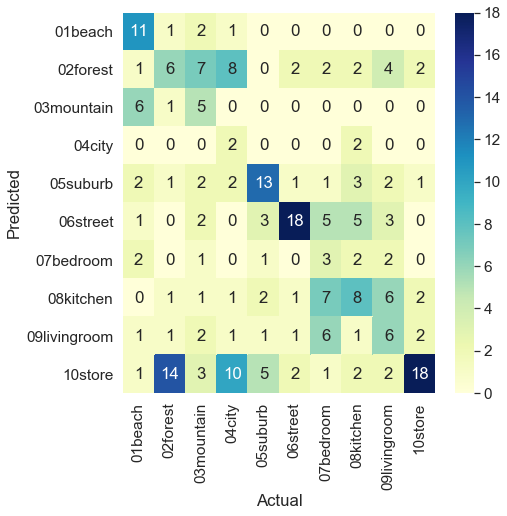

In [19]:
# Using y_test (true labels on the test data) and y_pred (the predicted labels), 
#  call the appropriate library function to display your confusion matrix, 
#  ensuring that the labels corectly match up with the folder names given
'*** Enter your code below'
import seaborn as sn
dataFrameConfusionMatrix = pd.DataFrame(confusionMatrix, index = [i for i in imageClasses], columns = [i for i in imageClasses])
plt.figure(figsize = (7,7))
sn.set(font_scale=1.4)
sn.heatmap(dataFrameConfusionMatrix, annot=True, fmt='d', cmap="YlGnBu")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.savefig('confusionMatrix.png')
plt.show()